In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import AdamW
import random

model_checkpoint = "EleutherAI/gpt-neo-125m"

# Add this at the top of your notebook
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


/home/ubuntu/ml-takehome/slingshot-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
print("Loading tokenizer, baseline LM model, and baseline label model...")
# Load the tokenizer, and both the LM model (for curiosity) and the label model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
# lm_model = AutoModelForCausalLM.from_pretrained(model_checkpoint)
label_model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=5,
).to(DEVICE)

Loading tokenizer, baseline LM model, and baseline label model...


Some weights of GPTNeoForTokenClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Quick check to see if the tokenizer works
inputs = tokenizer("My name is Phillip", return_tensors="pt")
inputs = inputs.to(DEVICE)

# Sample the pretrained LM model
# lm_outs = lm_model(**inputs) # shape: torch.Size([1, 4, 50257])

# Sample the untrained label model
label_outs = label_model(**inputs) # shape: torch.Size([1, 4, 5])

print(label_outs.logits.shape) # torch.float32
print(label_outs)

torch.Size([1, 4, 5])
TokenClassifierOutput(loss=None, logits=tensor([[[-0.2320,  1.1895,  0.8982,  1.8937, -3.3751],
         [-0.0375, -0.6073, -0.0125,  0.2561, -1.3983],
         [ 1.1693, -0.9159, -1.1021, -0.1131, -1.5073],
         [ 0.5287,  0.4123,  0.2568,  1.2632, -3.2422]]], device='cuda:0',
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)


In [4]:
# Import from the local IMDB Dataset.csv
print("Loading IMDB Dataset..")
# 67 MB, 50k rows, 2 columns: review, sentiment; sentiment is either 'positive' or 'negative'
df = pd.read_csv("data/IMDB Dataset.csv")
# df = df.head(1000) # TRUNCATE THE DATAFRAME TO 1000 ROWS TO TEST


# Function to split data into train and test sets
def train_test_split(data, test_size=0.1):
    data_size = len(data)
    test_size = int(data_size * test_size)
    indices = list(range(data_size))
    random.shuffle(indices)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Split the data into train and test sets
random.seed(404)  # for reproducibility
train_df, test_df = train_test_split(df, test_size=0.1)
print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")


# Constants we'll use
SEQ_LENGTH = 512 # Was using 2048, but running out of memory on GPU
BATCH_SIZE = 16
NUM_CLASSES = 5 # 5-star sentiment, we may try binary sentiment later; Curious since our labels
# are two classes (positive, negative), if 5-star sentiment will give us a smoother range
# of changing sentiment for confusing reviews, or if it'll barbell to 0 and 4


print("Extracting sentiment labels...")
train_sentiment_labels = torch.tensor([NUM_CLASSES-1 if s == "positive" else 0 for s in train_df["sentiment"]], dtype=torch.long)
test_sentiment_labels = torch.tensor([NUM_CLASSES-1 if s == "positive" else 0 for s in test_df["sentiment"]], dtype=torch.long)

# Tokenize the reviews and attach that to the dataframe
# 2048 is the max length of the reviews
tokenizer.pad_token = tokenizer.eos_token
def extract_tokens(review):
    # Returns [input_ids, attention_mask] for every review, each of shape [1, SEQ_LENGTH]
    tokenizer_out = tokenizer(review, return_tensors="pt", truncation=True, max_length=SEQ_LENGTH, padding="max_length")
    input_ids, attention_mask = tokenizer_out.input_ids, tokenizer_out.attention_mask
    return input_ids, attention_mask
# Convert reviews to token tensors
print("Tokenizing reviews...")
train_review_tokens_arr = [extract_tokens(review) for review in train_df['review']]
test_review_tokens_arr = [extract_tokens(review) for review in test_df['review']]
print(f"Train Samples: {len(train_review_tokens_arr)}, Test Samples: {len(test_review_tokens_arr)}")
print(f"Shape of first train item: {train_review_tokens_arr[0][0].shape}")

Loading IMDB Dataset..
Train set size: 45000, Test set size: 5000
Extracting sentiment labels...
Tokenizing reviews...
Train Samples: 45000, Test Samples: 5000
Shape of first train item: torch.Size([1, 512])


In [5]:
# Get a baseline loss for the untrained label model
total_loss = 0
num_batches = 0
batch_losses = []

def plot_loss(losses, title="Loss over batches", xlabel="Batch", ylabel="Loss"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def process_batches(train=False, is_train_set=True, epochs=1):
    total_loss = 0
    num_batches = 0
    batch_losses = []

    # Set the model to train or eval mode
    label_model.train(train)

    # Choose the appropriate dataset
    review_tokens = train_review_tokens_arr if is_train_set else test_review_tokens_arr
    sentiment_labels = train_sentiment_labels if is_train_set else test_sentiment_labels

    # Create optimizer if in training mode
    optimizer = AdamW(label_model.parameters(), lr=1e-5) if train else None

    epoch_losses = []
    for epoch in range(epochs):
        epoch_total_loss = 0
        epoch_num_batches = 0
        print(f"Epoch {epoch + 1}/{epochs}")
        for i in range(0, len(review_tokens), BATCH_SIZE):
            batch = review_tokens[i:i+BATCH_SIZE]
            y_true_batch = sentiment_labels[i:i+BATCH_SIZE]
            y_true_batch = y_true_batch.to(DEVICE)

            # Expand y_true_batch to (batch_size, sequence_length)
            y_true_batch = y_true_batch.unsqueeze(1).repeat(1, SEQ_LENGTH).view(-1)

            # Prepare input for the model
            input_ids = torch.cat([item[0] for item in batch], dim=0).to(DEVICE)
            attention_mask = torch.cat([item[1] for item in batch], dim=0).to(DEVICE)

            # Get the logits for the batch
            label_outs_batch = label_model(input_ids=input_ids, attention_mask=attention_mask)

            # Reshape logits to (batch_size * sequence_length, num_classes)
            logits = label_outs_batch.logits.view(-1, NUM_CLASSES)

            # Compute the loss for the batch
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(logits, y_true_batch)
            batch_loss = loss.item()

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update progress
            progress = (i + BATCH_SIZE) / len(review_tokens) * 100
            print(f"\rProcessing: [{i+BATCH_SIZE:5d}/{len(review_tokens):5d}] {progress:6.2f}% | Batch {num_batches + 1} loss: {batch_loss:.4f}", end="", flush=True)

            # Accumulate the loss
            total_loss += batch_loss
            epoch_total_loss += batch_loss
            num_batches += 1
            epoch_num_batches += 1
            batch_losses.append(batch_loss)

            # Clear unnecessary tensors
            del input_ids, attention_mask, y_true_batch, label_outs_batch, logits, loss
            torch.cuda.empty_cache()
        # Newline so the progress bar doesn't get flushed
        print()

        # Calculate and print the average loss for the epoch
        epoch_average_loss = epoch_total_loss / epoch_num_batches
        epoch_losses.append(epoch_average_loss)
        print(f"Epoch {epoch + 1} average loss: {epoch_average_loss:.4f}")

    # Calculate and print the overall average loss
    overall_average_loss = total_loss / num_batches
    print(f"\nOverall average loss: {overall_average_loss:.4f}")

    plot_loss(batch_losses, title="Loss over batches", xlabel="Batch", ylabel="Loss")

Processing baseline test set (untrained):
Epoch 1/1
Processing: [ 5008/ 5000] 100.16% | Batch 313 loss: 1.7610
Epoch 1 average loss: 1.7873

Overall average loss: 1.7873


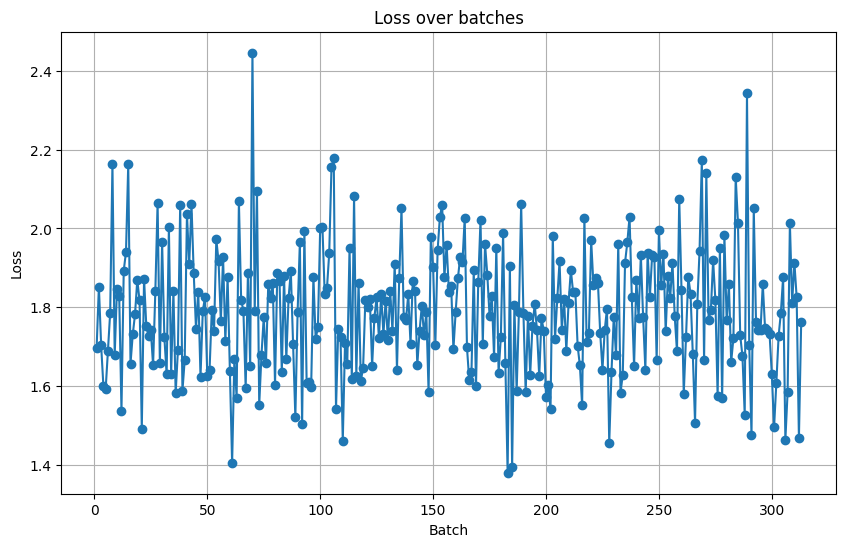

In [6]:
print("Processing baseline test set (untrained):")
process_batches(train=False, is_train_set=False)

Training:
Epoch 1/1
Processing: [45008/45000] 100.02% | Batch 2813 loss: 0.1527
Epoch 1 average loss: 0.3781

Overall average loss: 0.3781


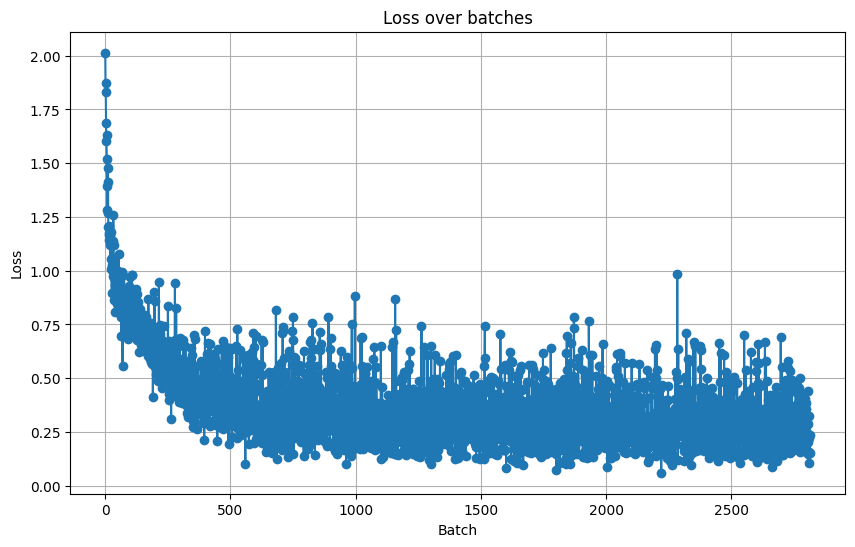

Processing test set (post-training):
Epoch 1/1
Processing: [ 5008/ 5000] 100.16% | Batch 313 loss: 0.7556
Epoch 1 average loss: 0.2806

Overall average loss: 0.2806


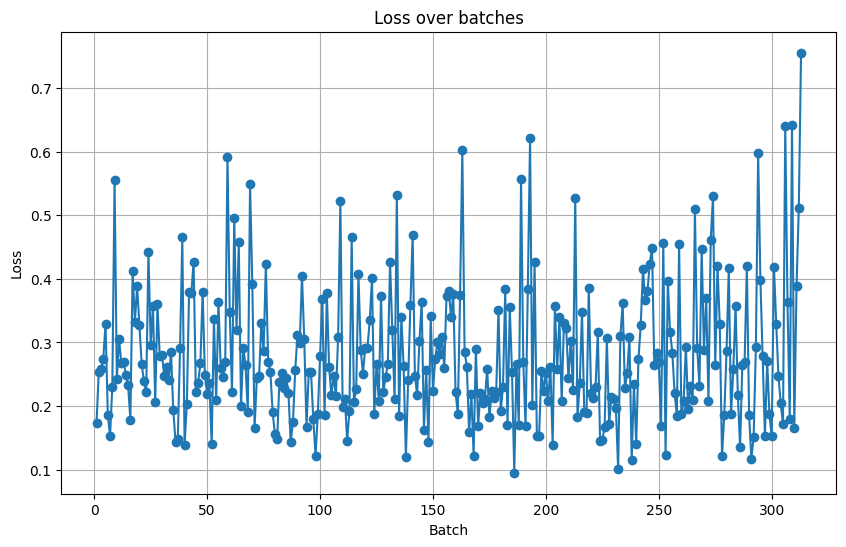

In [7]:
########
# Big Training Run
########
print("Training:")
process_batches(train=True, is_train_set=True, epochs=1)

print("Processing test set (post-training):")
process_batches(train=False, is_train_set=False)

In [10]:
def predict_sentiment(text, model=label_model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=SEQ_LENGTH, padding="max_length")
    inputs = inputs.to(DEVICE)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculations
    with torch.no_grad():
        # Get the model outputs
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get the predicted classes for each token
    predicted_classes = torch.argmax(logits, dim=-1)

    # Map the predicted classes to sentiment labels
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}

    # Get the overall sentiment (mode of all token predictions)
    overall_sentiment_class = torch.mode(predicted_classes[0]).values.item()
    overall_sentiment = sentiment_map[overall_sentiment_class]

    # Calculate overall confidence (mean of highest probabilities for each token)
    overall_confidence = torch.mean(torch.max(probabilities[0], dim=1).values).item()

    # Decode tokens and pair with their predicted classes
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    # Found this 'Ġ' character is space token, so removing it
    token_sentiments = [(token.replace('Ġ', ''), predicted_classes[0, i].item()) 
                        for i, token in enumerate(tokens) 
                        if token not in [tokenizer.pad_token, '<|endoftext|>']]

    return {
        "overall_sentiment": overall_sentiment,
        "overall_confidence": overall_confidence,
        "token_sentiments": token_sentiments
    }

# Example usage
sample_text = "Shitty. Except it fucking SUUUUCKED. Bad!"
result = predict_sentiment(sample_text, model=label_model)

print(f"Input text: {sample_text}")
print(f"Overall sentiment: {result['overall_sentiment']}")
print(f"Overall confidence: {result['overall_confidence']:.4f}")
print("\nToken-wise sentiment:")
print(" ".join([f"{token}({sentiment})" for token, sentiment in result['token_sentiments']]))

Input text: Shitty. Except it fucking SUUUUCKED. Bad!
Overall sentiment: Very Negative
Overall confidence: 0.9341

Token-wise sentiment:
Sh(4) itty(0) .(0) Except(0) it(0) fucking(0) SU(0) UU(0) UCK(0) ED(0) .(0) Bad(0) !(0)


In [11]:
import os

def save_model_weights(model, file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    torch.save(model.state_dict(), file_path)
    print(f"Model weights saved to {file_path}")

def load_model_weights(model, file_path):
    if os.path.exists(file_path):
        model.load_state_dict(torch.load(file_path))
        print(f"Model weights loaded from {file_path}")
    else:
        print(f"No weights file found at {file_path}")
    return model

# Example usage:
# Save the model weights
save_model_weights(label_model, "model_weights/imdb_sentiment_label_model.pth")

# To load the weights later:
loaded_label_model = load_model_weights(label_model, "model_weights/imdb_sentiment_label_model.pth")

predict_sentiment("This movie was absolutely fantastic! Great! I loved every minute of it. Except it fucking SUUUUCKED. Bad!", model=loaded_label_model)

Model weights saved to model_weights/imdb_sentiment_label_model.pth


/tmp/ipykernel_2046/489711667.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


Model weights loaded from model_weights/imdb_sentiment_label_model.pth


{'overall_sentiment': 'Very Positive',
 'overall_confidence': 0.6609187126159668,
 'token_sentiments': [('This', 0),
  ('movie', 0),
  ('was', 0),
  ('absolutely', 0),
  ('fantastic', 4),
  ('!', 4),
  ('Great', 4),
  ('!', 4),
  ('I', 4),
  ('loved', 4),
  ('every', 4),
  ('minute', 4),
  ('of', 4),
  ('it', 4),
  ('.', 4),
  ('Except', 4),
  ('it', 4),
  ('fucking', 4),
  ('SU', 4),
  ('UU', 4),
  ('UCK', 4),
  ('ED', 4),
  ('.', 4),
  ('Bad', 4),
  ('!', 4)]}